# Pitch Performance Prediction - Open Biomechanics Project

### By: Jiso Awe

This project is intended to utilize biomechanics data to predict pitch speed, utilizing data from Driveline's Open Biomechanics Project.

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor, plot_importance

In [44]:
biomech = pd.read_csv("pitching_poi_metrics.csv")
metadata = pd.read_csv("pitching_metadata.csv")

In [45]:
biomech.head()

,session_pitch,session,p_throws,pitch_type,pitch_speed_mph,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,...,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,1031_2,1031,R,FF,90.4,4533.2480,2445.8177,958.0878,32.3152,109.9971,...,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,1031_3,1031,R,FF,90.4,4571.1735,2389.5438,969.5766,32.5547,109.1065,...,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636
2,1097_1,1097,R,FF,77.6,4165.3055,2426.3029,1090.2269,33.1477,123.4752,...,1094.7686,1283.0751,58.3164,957.3923,245.4411,1767.4604,2010.5341,61.5594,4.4432,52.9333
3,1097_2,1097,R,FF,77.0,3832.1715,2424.0493,1105.2275,27.9286,124.6578,...,1187.5810,1354.7150,58.7397,860.3796,280.5177,1715.1864,1864.0488,66.6789,6.4897,54.3727
4,1097_3,1097,R,FF,76.1,3970.7971,2497.6253,1110.4850,28.9909,124.8308,...,1214.0065,1425.2124,58.0297,1066.6047,337.4227,2120.4510,2283.1749,65.9014,7.2019,106.2719


In [46]:
metadata.head()

,user,session,session_pitch,session_mass_kg,session_height_m,age_yrs,playing_level,pitch_speed_mph,filename_new,modelname_new
0,750,1031,1031_2,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_013_FF_904.c3d,000750_001031_model.c3d
1,750,1031,1031_3,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_014_FF_904.c3d,000750_001031_model.c3d
2,774,1097,1097_1,101.1528,1.9304,19.41,college,77.6,000774_001097_76_223_001_FF_776.c3d,000774_001097_model.c3d
3,774,1097,1097_2,101.1528,1.9304,19.41,college,77.0,000774_001097_76_223_005_FF_770.c3d,000774_001097_model.c3d
4,774,1097,1097_3,101.1528,1.9304,19.41,college,76.1,000774_001097_76_223_006_FF_761.c3d,000774_001097_model.c3d


In [47]:
biomech.shape

(411, 81)

In [48]:
metadata.shape

(411, 10)

In [49]:
# They have the same amount of rows, they can easily be joined
merged_data = pd.merge(metadata, biomech, on = ["session_pitch", "session"])
merged_data.shape

(411, 89)

In [50]:
merged_data.head()

,user,session,session_pitch,session_mass_kg,session_height_m,age_yrs,playing_level,pitch_speed_mph_x,filename_new,modelname_new,...,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,750,1031,1031_2,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_013_FF_904.c3d,000750_001031_model.c3d,...,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,750,1031,1031_3,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_014_FF_904.c3d,000750_001031_model.c3d,...,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636
2,774,1097,1097_1,101.1528,1.9304,19.41,college,77.6,000774_001097_76_223_001_FF_776.c3d,000774_001097_model.c3d,...,1094.7686,1283.0751,58.3164,957.3923,245.4411,1767.4604,2010.5341,61.5594,4.4432,52.9333
3,774,1097,1097_2,101.1528,1.9304,19.41,college,77.0,000774_001097_76_223_005_FF_770.c3d,000774_001097_model.c3d,...,1187.5810,1354.7150,58.7397,860.3796,280.5177,1715.1864,1864.0488,66.6789,6.4897,54.3727
4,774,1097,1097_3,101.1528,1.9304,19.41,college,76.1,000774_001097_76_223_006_FF_761.c3d,000774_001097_model.c3d,...,1214.0065,1425.2124,58.0297,1066.6047,337.4227,2120.4510,2283.1749,65.9014,7.2019,106.2719


In [51]:
list(merged_data.columns)

['user',
 'session',
 'session_pitch',
 'session_mass_kg',
 'session_height_m',
 'age_yrs',
 'playing_level',
 'pitch_speed_mph_x',
 'filename_new',
 'modelname_new',
 'p_throws',
 'pitch_type',
 'pitch_speed_mph_y',
 'max_shoulder_internal_rotational_velo',
 'max_elbow_extension_velo',
 'max_torso_rotational_velo',
 'max_rotation_hip_shoulder_separation',
 'max_elbow_flexion',
 'max_shoulder_external_rotation',
 'elbow_flexion_fp',
 'elbow_pronation_fp',
 'rotation_hip_shoulder_separation_fp',
 'shoulder_horizontal_abduction_fp',
 'shoulder_abduction_fp',
 'shoulder_external_rotation_fp',
 'lead_knee_extension_angular_velo_fp',
 'lead_knee_extension_angular_velo_br',
 'lead_knee_extension_angular_velo_max',
 'torso_anterior_tilt_fp',
 'torso_lateral_tilt_fp',
 'torso_rotation_fp',
 'pelvis_anterior_tilt_fp',
 'pelvis_lateral_tilt_fp',
 'pelvis_rotation_fp',
 'max_cog_velo_x',
 'torso_rotation_min',
 'max_pelvis_rotational_velo',
 'glove_shoulder_horizontal_abduction_fp',
 'glove_shoul

In [52]:
merged_data.isnull().sum().max()

8

In [53]:
merged_data = merged_data.dropna()

In [54]:
merged_data.isna().sum()

user                     0
session                  0
session_pitch            0
session_mass_kg          0
session_height_m         0
                        ..
lead_grf_z_max           0
lead_grf_mag_max         0
lead_grf_angle_at_max    0
peak_rfd_rear            0
peak_rfd_lead            0
Length: 89, dtype: int64

In [55]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 0 to 410
Data columns (total 89 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user                                       403 non-null    int64  
 1   session                                    403 non-null    int64  
 2   session_pitch                              403 non-null    object 
 3   session_mass_kg                            403 non-null    float64
 4   session_height_m                           403 non-null    float64
 5   age_yrs                                    403 non-null    float64
 6   playing_level                              403 non-null    object 
 7   pitch_speed_mph_x                          403 non-null    float64
 8   filename_new                               403 non-null    object 
 9   modelname_new                              403 non-null    object 
 10  p_throws                  

count    403.000000
mean      84.777667
std        4.694036
min       69.500000
25%       81.450000
50%       85.400000
75%       87.900000
max       94.400000
Name: pitch_speed_mph_x, dtype: float64


/Users/jisoluawe/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pitch_speed_mph_x', ylabel='Density'>

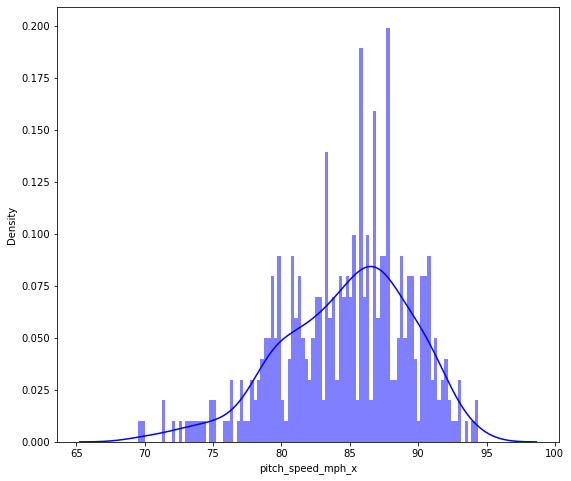

In [56]:
print(merged_data['pitch_speed_mph_x'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(merged_data['pitch_speed_mph_x'], color = 'b', bins = 100, hist_kws = {'alpha': 0.5})

# One Hot Encoding

In [57]:
cat = merged_data.select_dtypes(include = ['object', 'category'])
print(cat)

    session_pitch playing_level                         filename_new  \
0          1031_2       college  000750_001031_76_244_013_FF_904.c3d   
1          1031_3       college  000750_001031_76_244_014_FF_904.c3d   
2          1097_1       college  000774_001097_76_223_001_FF_776.c3d   
3          1097_2       college  000774_001097_76_223_005_FF_770.c3d   
4          1097_3       college  000774_001097_76_223_006_FF_761.c3d   
..            ...           ...                                  ...   
406        3252_1       college  000870_003252_74_195_002_FF_808.c3d   
407        3252_2       college  000870_003252_74_195_003_FF_808.c3d   
408        3252_3       college  000870_003252_74_195_005_FF_808.c3d   
409        3252_4       college  000870_003252_74_195_012_FF_833.c3d   
410        3252_5       college  000870_003252_74_195_014_FF_812.c3d   

               modelname_new p_throws pitch_type  
0    000750_001031_model.c3d        R         FF  
1    000750_001031_model.c3d     

In [58]:
merged_data = merged_data.drop(columns = ['user', 'session','session_pitch','filename_new', 'modelname_new'])

In [59]:
encoded_data = pd.get_dummies(merged_data)

In [60]:
encoded_data.head() # = encoded_data.drop(columns = ['playing_level', 'p_throws', 'pitch_type'])

,session_mass_kg,session_height_m,age_yrs,pitch_speed_mph_x,pitch_speed_mph_y,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,...,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead,playing_level_college,playing_level_high_school,playing_level_independent,playing_level_milb,p_throws_L,p_throws_R,pitch_type_FF
0,110.6784,1.9304,21.40,90.4,90.4,4533.2480,2445.8177,958.0878,32.3152,109.9971,...,63.3501,11.6564,170.4620,1,0,0,0,0,1,1
1,110.6784,1.9304,21.40,90.4,90.4,4571.1735,2389.5438,969.5766,32.5547,109.1065,...,62.3087,9.5715,183.6636,1,0,0,0,0,1,1
2,101.1528,1.9304,19.41,77.6,77.6,4165.3055,2426.3029,1090.2269,33.1477,123.4752,...,61.5594,4.4432,52.9333,1,0,0,0,0,1,1
3,101.1528,1.9304,19.41,77.0,77.0,3832.1715,2424.0493,1105.2275,27.9286,124.6578,...,66.6789,6.4897,54.3727,1,0,0,0,0,1,1
4,101.1528,1.9304,19.41,76.1,76.1,3970.7971,2497.6253,1110.4850,28.9909,124.8308,...,65.9014,7.2019,106.2719,1,0,0,0,0,1,1


In [70]:
y = encoded_data['pitch_speed_mph_x']
X = encoded_data.drop(['pitch_speed_mph_x', 'pitch_speed_mph_y'], axis = 1)

# Model Comparisions

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 22)

## Random Forest

In [63]:
model_RF = RandomForestRegressor()
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_test)

scores = cross_val_score(model_RF, X_test, y_test, cv = 5)
#print(scores)
print("R-Squared Score:", r2_score(y_test, y_pred_RF))
print("MAE Score:", mean_absolute_error(y_test, y_pred_RF))

R-Squared Score: 0.8345773763481177
MAE Score: 1.3520526315789434


## Gradient Boosting Regressor

In [64]:
model_GBR = GradientBoostingRegressor()
model_GBR.fit(X_train, y_train)
y_pred_gbr = model_GBR.predict(X_test)

scores = cross_val_score(model_GBR, X_test, y_test, cv = 5)

print("R-Squared Score:", r2_score(y_test, y_pred_gbr))
print("MAE Score:", mean_absolute_error(y_test, y_pred_gbr))

R-Squared Score: 0.8552100804059374
MAE Score: 1.2746129243389634


## SGD Regressor

In [65]:
model_SGD = SGDRegressor()
model_SGD.fit(X_train, y_train)
y_pred_sgd = model_SGD.predict(X_test)

scores = cross_val_score(model_SGD, X_test, y_test, cv = 5)

print("R-Squared Score:", r2_score(y_test, y_pred_sgd))
print("MAE Score:", mean_absolute_error(y_test, y_pred_sgd))

R-Squared Score: -1.1001393950195313e+35
MAE Score: 3.7173480465698234e+17


## XGBoost

In [66]:
model_XGBR = XGBRegressor(n_estimators = 200, objective = 'reg:squarederror')
model_XGBR.fit(X_train, y_train)
y_pred_XGB = model_XGBR.predict(X_test)

scores = cross_val_score(model_XGBR, X_test, y_test, cv = 10)

print("R-Squared Score:", r2_score(y_test, y_pred_XGB))
print("MAE Score:", mean_absolute_error(y_test, y_pred_XGB))

R-Squared Score: 0.8710624309918977
MAE Score: 1.186248767824102


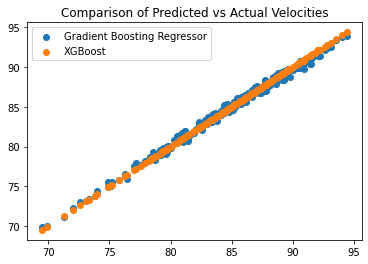

In [67]:
# Plotting comaparison of predicted velo vs actual
plt.figure()
plt.title('Comparison of Predicted vs Actual Velocities')
plt.scatter(y_train, model_GBR.predict(X_train), label = "Gradient Boosting Regressor")
plt.scatter(y_train, model_XGBR.predict(X_train), label = "XGBoost")
plt.legend()

# Feature Selection

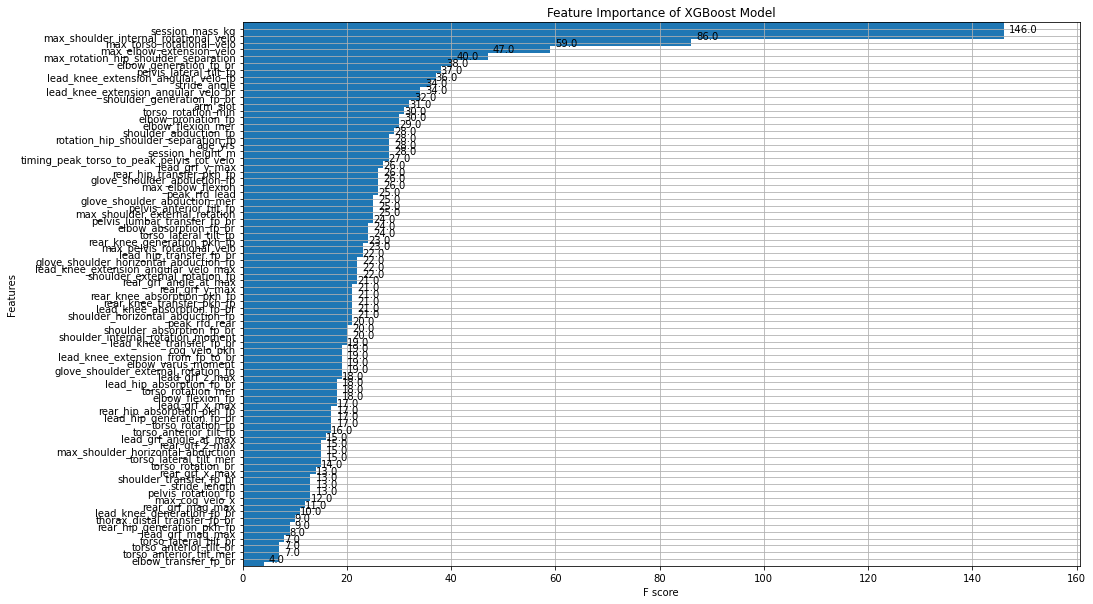

In [68]:
fig, ax = plt.subplots(ncols = 1, figsize = (15,10))

plot_importance(model_XGBR, height = 3, ax = ax, title = 'Feature Importance of XGBoost Model')
plt.show()

From plotting the feature importance of the XGBoost model, I found the model places a lot of importance on the pitchers mass (kg), maximum shoulder internal rotational velocity, and maximum torso rotational velocity. Here I will present some reasons why I believe the model placed high importance on these specific factors.

### Mass (kg)
When determining the ideal range for the ground reaction force (GRF), the pitcher should be generating the standard is 1.5x - 2x the pitchers body mass. GRF are an indictator of how well the pitcher is able to transfer the energy that is generated through their lower body. Generally higher GRF are correlated with higher pitching velocities. I believe that the reason the model is placing such a high level of importance on pitcher mass is because greater mass should produce higher GRF, which is correlated with velocity.

### Maximum Shoulder Internal Rotational Velocity
Internal shoulder rotation is the last movement the pitching sequence before ball release. It makes sense that the model would place high importance on this metric because the higher the velocity that internal shoulder rotation reaches the more energy is able to be released from the pitchers arm onto the ball as it is leaving their hand.

### Maximum Torso Rotational Velocity
Torso rotation is a movement that is fundamental to efficient energy transfer in pitching. When pitching the energy the generated from the lower body (GRF), are passed through the core and into the arm for the pitch. For this energy transfer to efficiently occur from lower body to core to upper body, the pitcher should have a swift torso rotation (core movement), so that the energy doesn't "leak out" during the pitching sequence. Additionally, higher torso rotational velocities are correlated with higher pitch velocities.

In [72]:
drop_cols = ['lead_knee_generation_fp_br', 'thorax_distal_transfer_fp_br', 'rear_hip_generation_pkh_fp',
             'lead_grf_mag_max', 'torso_lateral_tilt_br', 'torso_anterior_tilt_br',
             'torso_anterior_tilt_mer', 'elbow_transfer_fp_br']

X_train = X_train.drop(drop_cols, axis = 1)

X_test = X_test.drop(drop_cols, axis = 1)

'''dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]'''

# Hyperparameter Tuning

In [100]:
## hyperparameter tuning
model = XGBRegressor()

params = {"n_estimators": range(485,500, 1), #between 400-500, {450, 475, 480, 495, 493}
          "learning_rate" : [0.05, 0.1, 0.5], # 0.1
          "max_depth" : [2, 4, 8, 16], #max_depth consistently 2
          "reg_alpha" : [0, 5], # consistently 0
          "reg_lambda": [0, 5], # consistently 0
          "objective": ["reg:squarederror"]}

cv_xgb = GridSearchCV(estimator = model, param_grid = params,
                      scoring = 'neg_mean_absolute_error', cv= 5, n_jobs = -1)

cv_xgb.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [2],
                         'n_estimators': range(485, 500),
                         'objective': ['reg:squarederror'], 'reg_alpha': [0, 5],
                         'reg_lambda': [0, 5]},
             scoring='neg_mean_absolute_error')

In [101]:
cv_xgb.best_params_, cv_xgb.best_score_

({'learning_rate': 0.1,
  'max_depth': 2,
  'n_estimators': 493,
  'objective': 'reg:squarederror',
  'reg_alpha': 0,
  'reg_lambda': 0},
 -1.2595065307617193)

In [102]:
model1 = XGBRegressor(**cv_xgb.best_params_)
model1.fit(X_train, y_train)
y_pred_XGB1 = model1.predict(X_test)

scores = cross_val_score(model1, X_test, y_test, cv = 10)

print("R-Squared Score:", r2_score(y_test, y_pred_XGB1))
print("MAE Score:", mean_absolute_error(y_test, y_pred_XGB1))

R-Squared Score: 0.8821441925466708
MAE Score: 1.1797043076135167


In [ ]:
'''
results = pd.DataFrame(cv_xgb.cv_results_)

plt.figure(figsize=(10, 6))

# Create a scatter plot for each learning rate
for lr in params['learning_rate']:
    subset = results[results['param_learning_rate'] == lr]
    plt.scatter(subset['param_n_estimators'], -subset['mean_test_score'], label=f'learning_rate={lr}', s=100)

plt.xlabel('Number of Estimators')
plt.ylabel('Negative Mean Squared Error')
plt.title('Grid Search Results')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()'''